# Generate a QC report showing the difference in number of single-cells after QC

## Import libraries

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(platetools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(arrow))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘platetools’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”


## Set paths to input dir and output dir

In [2]:
plate <- "localhost230405150001"

# Paths to parquet files to generate QC report
path_to_orig_plate4 <- file.path("./data/converted_profiles/", paste0(plate, "_converted.parquet"))
path_to_cleaned_plate4 <- file.path("./data/cleaned_profiles/", paste0(plate, "_cleaned.parquet"))

# Output path for bar chart
orig_plate4_output_file <- file.path("./qc_figures/", paste0(plate, "_orig_platemap.png"))

# Output path for platemap
clean_plate4_output_file <- file.path("./qc_figures/", paste0(plate, "_cleaned_platemap.png"))


## Load in parquet files

In [3]:
# Read in CSV files
orig_df <- arrow::read_parquet(path_to_orig_plate4)
cleaned_df <- arrow::read_parquet(path_to_cleaned_plate4)

# Summarize cleaned data into cell counts per well
filtered_cleaned_df <- cleaned_df %>%
  group_by(Image_Metadata_Well) %>%
  summarize(Metadata_Count_Per_Well = n())

# Summarize non-QC data into cell counts per well
filtered_orig_df <- orig_df %>%
  group_by(Image_Metadata_Well) %>%
  summarize(Metadata_Count_Per_Well = n())

dim(filtered_cleaned_df)      
head(filtered_cleaned_df)

[1] 45  2

Image_Metadata_Well,Metadata_Count_Per_Well
<chr>,<int>
B02,465
B03,410
B04,323
B05,490
B06,380
B07,516


## Generate platemap with the original number of single cells after CytoTable conversion

Warning message:
“Warning: Your well label count ( 45 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


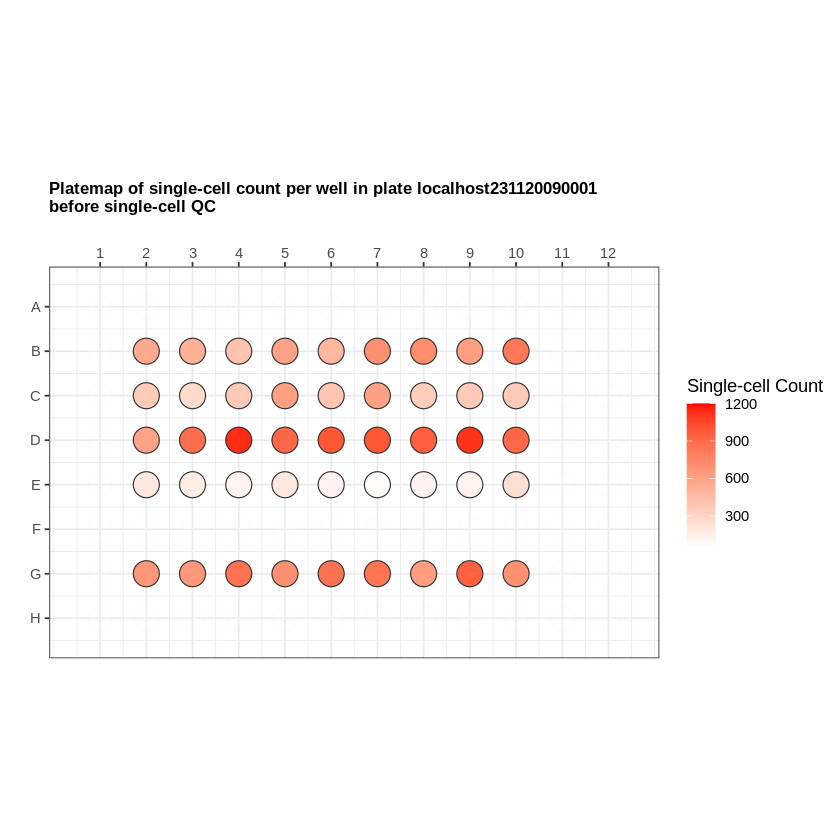

In [4]:
orig_platemap <- platetools::raw_map(
    data = filtered_orig_df$Metadata_Count_Per_Well,
    well = filtered_orig_df$Image_Metadata_Well,
    plate = 96,
    size = 7
    ) +

    ggtitle(paste("Platemap of single-cell count per well in plate localhost231120090001\nbefore single-cell QC")) +
    theme(plot.title = element_text(size = 10, face = "bold")) +
    scale_fill_gradient(name = "Single-cell Count", low = "white", high = "red", limits = c(50, 1200))

    ggsave(
    orig_plate4_output_file,
    orig_platemap,
    dpi = 500,
    height = 3.5,
    width = 6
    )

# Display the plot in the notebook
orig_platemap

## Generate platemap with the number of single-cells after QC

Warning message:
“Warning: Your well label count ( 45 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


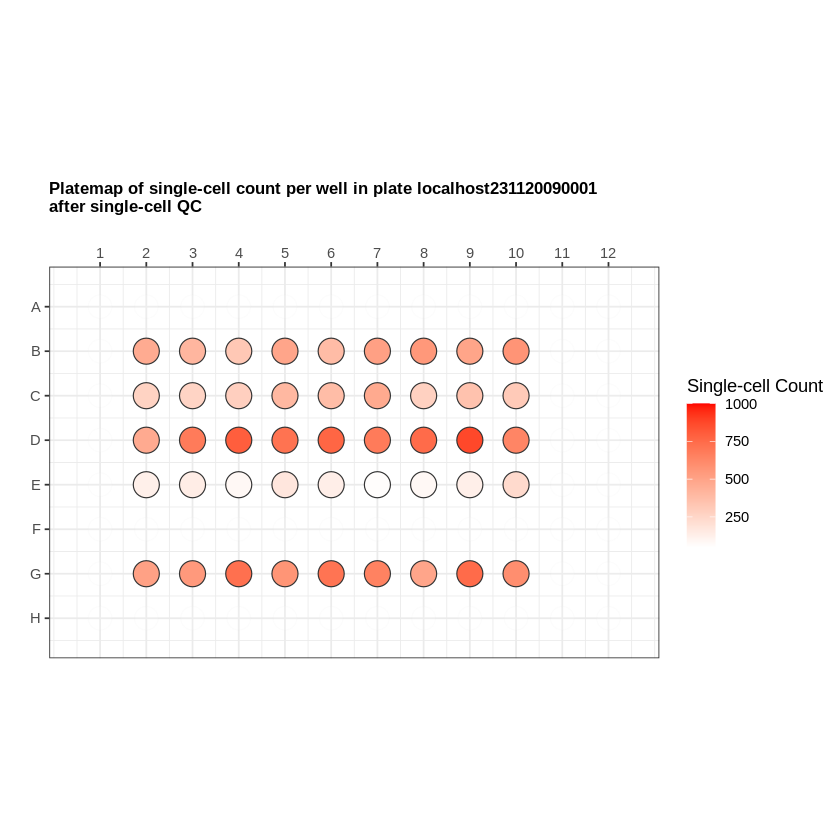

In [5]:
cleaned_platemap <- platetools::raw_map(
    data = filtered_cleaned_df$Metadata_Count_Per_Well,
    well = filtered_cleaned_df$Image_Metadata_Well,
    plate = 96,
    size = 7
    ) +

    ggtitle(paste("Platemap of single-cell count per well in plate localhost231120090001\nafter single-cell QC")) +
    theme(plot.title = element_text(size = 10, face = "bold")) +
    scale_fill_gradient(name = "Single-cell Count", low = "white", high = "red", limits = c(50, 1000))

    ggsave(
    clean_plate4_output_file,
    cleaned_platemap,
    dpi = 500,
    height = 3.5,
    width = 6
    )

# Display the plot in the notebook
cleaned_platemap

## Output the number of single-cells across cell type

In [6]:
# Load in plate data that includes metadata
annot_df <- arrow::read_parquet(file.path("./data/single_cell_profiles", paste0(plate, "_sc_annotated.parquet")))

# Mutate cell type to be capitalized if needed and print the number of cells per cell type
count_failing_healthy <- annot_df %>%
  mutate(Metadata_cell_type = ifelse(
    str_detect(Metadata_cell_type, "^[a-z]"), 
    str_to_title(Metadata_cell_type), 
    Metadata_cell_type)) %>%
  filter(Metadata_cell_type %in% c("Failing", "Healthy")) %>%
  group_by(Metadata_cell_type) %>%
  summarise(Count = n())

count_failing_healthy

Metadata_cell_type,Count
<chr>,<int>
Failing,16134
Healthy,4189
